<a href="https://colab.research.google.com/github/AbhinavRobinson/CS_WORKHORSE/blob/master/StockPredictionUsingRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Prediction Using RNN
##For Education Use Only
> Disclaimer : Do Not use this for real world purposes

Hi there!

In this Assignment of EMAT203L , We make a stock prediction algorithm.

One way to achive this is using RNN, implemented via TensorFlow. 
We will be using TensorFlow 1.15 for this. This program may not be compatible with TensorFlow 2.X.X.
Read the Documentation carefully!

-Abhinav Robinson :)




#Method

We are only concerned with the "Close" data at this moment.
Hence we will use pandas to cleanup the data, enter data inside a Dataframe, with only the relavant columns.

In [1]:
import pandas as pd

# Lets check the data :)
main_df = pd.DataFrame()

# Lets combine all data in one dataframe
ratios = ["BJB-INR","BBA-INR","PNB-INR","YES-INR"]
for ratio in ratios:
  dataset = f"{ratio}.csv"
  df = pd.read_csv(dataset,  
                   names=["time","open","high","low","close"])

  df.rename(columns={"close": f"{ratio}_close"}, 
            inplace=True)
  df.set_index("time",inplace=True)
  df = df[[f"{ratio}_close"]]

  if len(main_df) == 0:
    main_df = df
  else:
    main_df = main_df.join(df)

# Lets Test our data cleanup
print(main_df.head())

            BJB-INR_close  BBA-INR_close  PNB-INR_close  YES-INR_close
time                                                                  
30-08-2019        3332.50          92.60          64.90          59.95
29-08-2019        3299.30          91.80          65.05          57.40
28-08-2019        3326.35          94.50          65.65          59.50
27-08-2019        3357.75          97.30          67.15          64.50
26-08-2019        3324.25          95.05          65.75          62.90


In [0]:
import time
# Now we define some time variables
# Based on last 15 days
SEQ_LEN = 15
# We predict next 3 day
# We will be going 3 divisions ahead, as a rule of thumb
FUTURE_PERIOD_PREDICT = 1
# on the YesBank EQ Close
RATIO_TO_PREDICT = "YES-INR"
# Defining no. of EPOCHS
EPOCHS = 10
# Defining Batch Size
BATCH_SIZE = 64
# Adding Names
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [0]:
def classify(current, future):
  # aka, good thing, buy
  if float(future) > float(current): return 1
  # not a good thing, maybe? ;)
  else: return 0

In [40]:
# Lets add future price as a column
main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)
print(main_df[[f"{RATIO_TO_PREDICT}_close", "future"]].head())

            YES-INR_close  future
time                             
26-08-2019          62.90   59.25
23-08-2019          59.25   56.30
22-08-2019          56.30   65.40
21-08-2019          65.40   71.20
20-08-2019          71.20   76.65


In [41]:
# add output of classify to a list shown as a column
main_df['target'] = list(map(classify, 
                             main_df[f"{RATIO_TO_PREDICT}_close"],
                             main_df["future"]))

print(main_df[[f"{RATIO_TO_PREDICT}_close", "future", "target"]].head(10))

            YES-INR_close  future  target
time                                     
26-08-2019          62.90   59.25       0
23-08-2019          59.25   56.30       0
22-08-2019          56.30   65.40       1
21-08-2019          65.40   71.20       1
20-08-2019          71.20   76.65       1
19-08-2019          76.65   79.45       1
16-08-2019          79.45   76.55       0
14-08-2019          76.55   73.60       0
13-08-2019          73.60   82.15       1
09-08-2019          82.15   89.20       1


In [0]:
# Noramlly data is sorted, but just in case
# .values converts index values to numpy array
times = sorted(main_df.index.values)
# now we seperate the last 5% data for test data
# last_5pct is a unix timestamp
last_5pct = times[-int(0.05*len(times))]

# Now we split the data
validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]

In [0]:
# Import some more libraries ;_;
from sklearn import preprocessing
from collections import deque
import random
import numpy as np

# Preprocess DF to scale all values of diff. coins on one scale
# and add percent change
def preprocess_df(df):
  df = df.drop('future',1)

  for col in df.columns:
    if col != 'target':
      df[col] = df[col].pct_change()
      df.dropna(inplace=True)
      df[col] = preprocessing.scale(df[col].values)

  df.dropna(inplace=True)

  sequential_data = []
  prev_days = deque(maxlen = SEQ_LEN)
  print(df.head())

  for i in df.values:
    prev_days.append([n for n in i[:-1]]) 
    if len(prev_days) == SEQ_LEN:
      sequential_data.append([np.array(prev_days), i[-1]])

  random.shuffle(sequential_data)

  buys = []
  sells = []

  for seq, target, in sequential_data:
    if target == 0:
      sells.append([seq, target])
    elif target == 1:
      buys.append([seq, target])

  random.shuffle(buys)
  random.shuffle(sells)

  lower = min(len(buys), len(sells))

  # Upto 30K
  buys = buys[:lower]
  sells = sells[:lower]

  sequential_data = buys+sells
  random.shuffle(sequential_data)

  X = []
  y = []

  for seq,target in sequential_data:
    X.append(seq)
    y.append(target)

  return np.array(X), y

In [44]:
train_x , train_y = preprocess_df(main_df)
validation_x , validation_y = preprocess_df(validation_main_df)

            BJB-INR_close  BBA-INR_close  PNB-INR_close  YES-INR_close  target
time                                                                          
19-08-2019       0.504848       1.478318       0.951350       2.414274       1
16-08-2019       0.199255      -0.067334       0.421475       1.150536       0
14-08-2019      -0.484479      -0.509245      -1.441982      -1.155874       0
13-08-2019      -0.748981      -1.131511      -0.142796      -1.220172       1
09-08-2019       2.571365       0.660720       0.666083       3.665640       1
            BJB-INR_close  BBA-INR_close  PNB-INR_close  YES-INR_close  target
time                                                                          
26-03-2019      -0.122491      -0.215198       0.216931       0.574202       0
27-02-2019      -0.608769      -1.440625      -1.688417      -0.699928       1
26-02-2019       0.480068      -0.003950      -0.089529       0.095751       0
26-12-2018       0.068048       1.311888       0.442

In [45]:
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont Buys : {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont Buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

train data: 1988 validation: 94
Dont Buys : 994, buys: 994
VALIDATION Dont Buys: 47, buys: 47


In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [47]:
!mkdir "models"

mkdir: cannot create directory ‘models’: File exists


In [76]:
model = Sequential()

model.add(CuDNNLSTM(128, 
                    input_shape=(train_x.shape[1:]), 
                    return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, 
                    input_shape=(train_x.shape[1:]), 
                    return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

# tensorboard = TensorBoard(log_dir=f'logs/{NAME}')

# filepath = "RNN_Final-{epoch:02d}-{val_acc: .3f}"
# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, 
#                                                       monitor= 'val_acc',
#                                                       verbose=1,
#                                                       save_best_only = True,
#                                                       mode='max'))

history = model.fit(
    train_x, train_y,
    batch_size= BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x,validation_y)
)

Train on 1988 samples, validate on 94 samples
Epoch 1/10
1988/1988 [==============================] - 5s 2ms/sample - loss: 0.8710 - acc: 0.5292 - val_loss: 0.6929 - val_acc: 0.5000
Epoch 2/10
1988/1988 [==============================] - 1s 330us/sample - loss: 0.7939 - acc: 0.5156 - val_loss: 0.6932 - val_acc: 0.5106
Epoch 3/10
1988/1988 [==============================] - 1s 343us/sample - loss: 0.7669 - acc: 0.5267 - val_loss: 0.6946 - val_acc: 0.5000
Epoch 4/10
1988/1988 [==============================] - 1s 345us/sample - loss: 0.7529 - acc: 0.5302 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/10
1988/1988 [==============================] - 1s 334us/sample - loss: 0.7369 - acc: 0.5277 - val_loss: 0.6951 - val_acc: 0.5000
Epoch 6/10
1988/1988 [==============================] - 1s 338us/sample - loss: 0.7193 - acc: 0.5513 - val_loss: 0.6925 - val_acc: 0.4681
Epoch 7/10
1988/1988 [==============================] - 1s 337us/sample - loss: 0.7130 - acc: 0.5453 - val_loss: 0.6922 - val_ac

In [0]:
# We import matplotlib and create a function to plot history
import matplotlib.pyplot as plt

def plot_history(histories, key='acc'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

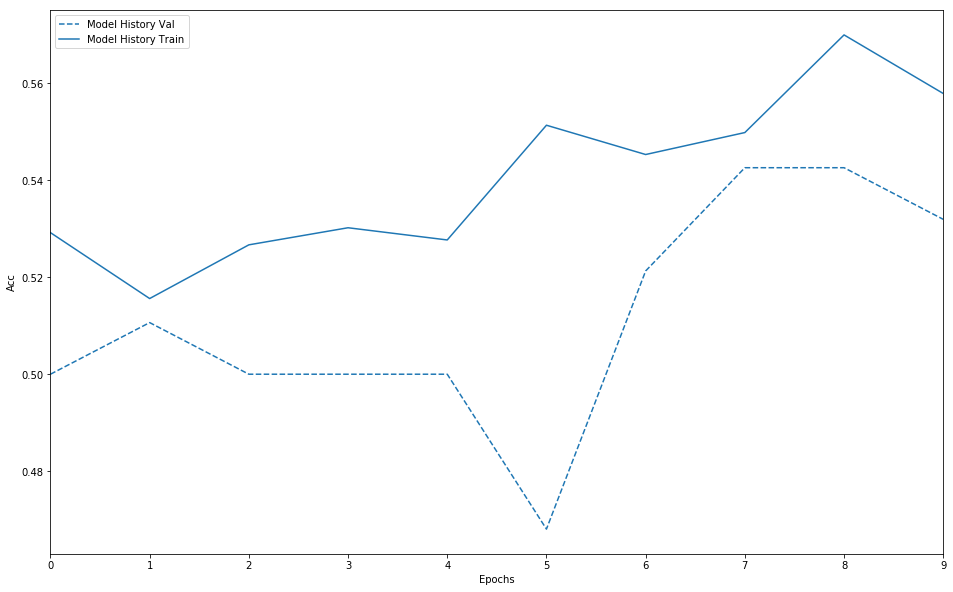

In [78]:
plot_history([('Model History',history)])